In [1]:
import pandas as pd
import numpy as np
from datetime import date,time,datetime
import matplotlib.pyplot as plt
data1 = pd.read_csv('/Users/xwx/Desktop/徐丸絮/研究生学习/发表论文/data/usefuldata.csv',index_col=0)
data1.head()

,date,type,direction,time_dept,time_arr,label,hour,time
index,,,,,,,,
2017-01-30 10:00:00,2017/1/30,平日,1,10:18:31,10:55:11,2200,10,2017/1/30 10
2017-01-02 06:00:00,2017/1/2,平日,1,6:41:09,7:20:10,2341,6,2017/1/2 6
2017-01-02 06:00:00,2017/1/2,平日,1,6:48:27,7:34:29,2762,6,2017/1/2 6
2017-01-02 06:00:00,2017/1/2,平日,1,6:58:12,7:41:01,2569,6,2017/1/2 6
2017-01-02 07:00:00,2017/1/2,平日,1,7:04:51,7:50:23,2732,7,2017/1/2 7


In [2]:
from sklearn import preprocessing
#提取需要的特征
data=data1[['date','direction','label']]
#对date,direction编码
values=data.values
encoder = preprocessing.LabelEncoder()#LabelEncoder是用来对分类型特征值进行编码，即对不连续的数值或文本进行编码
values[:,0] = encoder.fit_transform(values[:,0])
values[:,1] = encoder.fit_transform(values[:,1])
#归一化
min_max_scaler = preprocessing.MinMaxScaler()
values_minmax = min_max_scaler.fit_transform(values)

/Users/xwx/anaconda3/envs/WZTensorflow_Py37/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
#构造数据
from sklearn import preprocessing
#构造时间序列
'''
col=list()
col.append(data1.label.shift(1))
col.append(data1.label)
agg = pd.concat(col, axis=1)
agg.columns=['input_seq','output_seq']
agg.dropna(inplace=True)
'''
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #变量的个数
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1): #n_in代表输入往下退的次数，相当于把后n个挤掉了
        cols.append(df.shift(i))#将数据向下移动i格但是索引值不变
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]#存放变量名
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):#把后n+1个作为输出
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    #然后将输入输出合并 Var1（t-1）那一列代表的就是前t-1时刻var1的时间序列之后作为输入
    #var1(t)那一列代表后t时刻（t，t+1...t+n）的var1的时间序列，是之后的输出序列
    agg = pd.concat(cols, axis=1)
    agg.columns = names#为序列命名
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)#是否过滤空数据
    return agg

#定义LSTM的结构
timesteps=24
features=3

agg=series_to_supervised(values_minmax,timesteps,1)#构造成前timesteps个小时作为输入，下一个时刻作为输出

#预测值只有var3（t），去掉不需要的列
#agg.drop(agg.columns[[3,4]],axis=1,inplace=True)
agg.drop(['var1(t)','var2(t)'],axis=1,inplace=True)
agg.head()


,var1(t-24),var2(t-24),var3(t-24),var1(t-23),var2(t-23),var3(t-23),var1(t-22),var2(t-22),var3(t-22),var1(t-21),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
24,0.388889,0.0,0.035676,0.166667,0.0,0.073784,0.166667,0.0,0.187568,0.166667,...,0.166667,0.0,0.166757,0.166667,0.0,0.257027,0.166667,0.0,0.196757,0.422973
25,0.166667,0.0,0.073784,0.166667,0.0,0.187568,0.166667,0.0,0.135405,0.166667,...,0.166667,0.0,0.257027,0.166667,0.0,0.196757,0.166667,0.0,0.422973,0.140000
26,0.166667,0.0,0.187568,0.166667,0.0,0.135405,0.166667,0.0,0.179459,0.166667,...,0.166667,0.0,0.196757,0.166667,0.0,0.422973,0.166667,0.0,0.140000,0.406757
27,0.166667,0.0,0.135405,0.166667,0.0,0.179459,0.166667,0.0,0.148919,0.166667,...,0.166667,0.0,0.422973,0.166667,0.0,0.140000,0.166667,0.0,0.406757,0.146486
28,0.166667,0.0,0.179459,0.166667,0.0,0.148919,0.166667,0.0,0.100541,0.166667,...,0.166667,0.0,0.140000,0.166667,0.0,0.406757,0.166667,0.0,0.146486,0.165135


In [12]:
values=agg.values


#分割训练集与测试集（9000+3000）
X_train=values[0:9000,0:-1]
y_train=values[0:9000,-1]

X_test=values[9000:,0:-1]
y_test=values[9000:,-1]

#构造成LSTM需要的输入格式
X_train=X_train.reshape((9000,timesteps,features))
X_test=X_test.reshape((X_test.shape[0],timesteps,features))

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(9000, 24, 3) (9000,) (3142, 24, 3) (3142,)


In [13]:
#搭建模型
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#因为运行的时候好像有什么包冲突所以加一句这个，和模型本身无关

from keras. models import Sequential
from keras.models import *
from keras.layers import Input, Dense, Permute, LSTM
from keras.layers import Multiply 

#定义Attention层
def attention_3d_block(inputs):
    x = Permute((2,1))(inputs)#将input的形状转置，原因是只在时间步上Attention
    x = Dense(timesteps,activation="softmax")(x)
    attention_probs = Permute((2,1),name = "attention_vec")(x)
    multipy_layer = Multiply()([input_layer,attention_probs])
    return multipy_layer


# input layer
input_layer = Input(shape=(timesteps,features))
# attention_3d_block Attention层
attention_mul = attention_3d_block(input_layer)
# lstm layer
lstm_layer = LSTM(16,return_sequences=False)(attention_mul)
# output layer
output_layer = Dense(1)(lstm_layer)
model = Model([input_layer], outputs=[output_layer])



Train on 9000 samples, validate on 3142 samples
Epoch 1/40
 - 6s - loss: 0.0990 - val_loss: 0.0651
Epoch 2/40
 - 5s - loss: 0.0872 - val_loss: 0.0631
Epoch 3/40
 - 5s - loss: 0.0852 - val_loss: 0.0565
Epoch 4/40
 - 5s - loss: 0.0855 - val_loss: 0.0538
Epoch 5/40
 - 5s - loss: 0.0830 - val_loss: 0.0535
Epoch 6/40
 - 5s - loss: 0.0810 - val_loss: 0.0530
Epoch 7/40
 - 5s - loss: 0.0792 - val_loss: 0.0521
Epoch 8/40
 - 4s - loss: 0.0777 - val_loss: 0.0512
Epoch 9/40
 - 4s - loss: 0.0759 - val_loss: 0.0499
Epoch 10/40
 - 4s - loss: 0.0742 - val_loss: 0.0483
Epoch 11/40
 - 5s - loss: 0.0720 - val_loss: 0.0467
Epoch 12/40
 - 5s - loss: 0.0699 - val_loss: 0.0452
Epoch 13/40
 - 5s - loss: 0.0678 - val_loss: 0.0443
Epoch 14/40
 - 5s - loss: 0.0662 - val_loss: 0.0434
Epoch 15/40
 - 5s - loss: 0.0646 - val_loss: 0.0428
Epoch 16/40
 - 5s - loss: 0.0633 - val_loss: 0.0424
Epoch 17/40
 - 5s - loss: 0.0623 - val_loss: 0.0421
Epoch 18/40
 - 5s - loss: 0.0615 - val_loss: 0.0418
Epoch 19/40
 - 5s - loss:

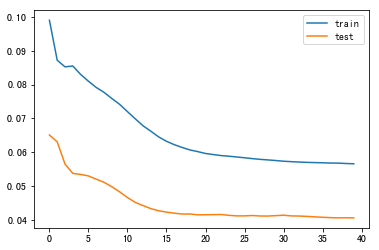

In [14]:
#模型训练
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=40, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [7]:
#模型可视化
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 3)        0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 3, 24)        0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3, 24)        600         permute_1[0][0]                  
__________________________________________________________________________________________________
attention_vec (Permute)         (None, 24, 3)        0           dense_1[0][0]                    
____________________________________________________________________________________________

In [8]:
#模型评估
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error
# make a prediction
X_test=X_test.reshape((X_test.shape[0],timesteps,features))
yhat = model.predict(X_test)#预测值也是[0,1]之间的，因此要转换回原来的值
X_test = X_test.reshape((X_test.shape[0],timesteps*features))
 
# invert scaling for forecast
inv_yhat = np.concatenate((X_test[:,0:features-1],yhat), axis=1)#按列的方式进行组合
inv_yhat = min_max_scaler.inverse_transform(inv_yhat)#从0~1反变换为真实数据
inv_yhat = inv_yhat[:,-1]
 
# invert scaling for actual
y=y_test.reshape(y_test.shape[0],1)
inv_y = np.concatenate(( X_test[:,0:features-1],y), axis=1)
inv_y = min_max_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
 
# calculate RMSE、MAE
h=data.label.values[9000:-1]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae=mean_absolute_error(inv_y, inv_yhat)
mape=100*np.mean(np.abs((inv_y-inv_yhat)/inv_y))
#print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.5f' % mape)

Test MAE: 150.266
Test MAPE: 5.32750


In [ ]:
#画出实际和预测曲线
plt.figure(figsize=(24,8))
plt.plot(list(range(len(inv_y))), inv_y, color='b')
plt.plot(list(range(len(inv_yhat))), inv_yhat, color='r')
plt.show()

In [ ]:
attention_model = Model(model.input,model.get_layer("attention_vec").output)
atten_X_test = attention_model.predict(X_test)#atten_X_test代表着每一个时间步的注意力权重
#plt.plot(list(range(len(atten_X_test))),atten_X_test)
atten_X_test.shape


In [ ]:
atten_X_test